In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import cross_validate, ShuffleSplit,train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor

%matplotlib inline

#DummyRegressor
#SimpleImputer

# Agreed upon cleaned dataset

In [2]:
dataset = pd.read_csv('data/kc_house_data.csv')

# Null waterfront values count as no waterfront
dataset['waterfront'] = dataset['waterfront'].fillna(0) 

dataset['date'] = pd.to_datetime(dataset['date'])
# Drop how many times house viewed
dataset.dropna(subset = ['view'], inplace = True)
# Make values with no house renovation the year it was built
dataset.yr_renovated.fillna(dataset.yr_built, inplace=True)
# Make Zipcode a str
dataset['zipcode'].astype(int)
# Make sqft basement a float and fill na with 0
dataset['sqft_basement'] = dataset['sqft_basement'].replace('?', np.nan).astype(float).fillna(0)


In [3]:
#Load in data
df_train = pd.read_csv('data/kc_house_data.csv') 
df_test = pd.read_csv('data/kc_house_data.csv')
df = pd.read_csv('data/kc_house_data.csv')


df['beds_baths'] = df['bedrooms'] + df['bathrooms']
df['waterfront'] = df['waterfront'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].replace('?',np.nan).astype(float).fillna(0)
df['zipcode'] = df['zipcode'].apply(str)
df = df.drop(['id','date','view'],axis=1)
df.yr_renovated.fillna(df.yr_built, inplace=True)


# Create a Dummy Dataframe then join to our main one

In [4]:
df['price'].min(), df['price'].max(), df['price'].mean(), df['price'].median()

(78000.0, 7700000.0, 540296.5735055795, 450000.0)

C:\Users\sethk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


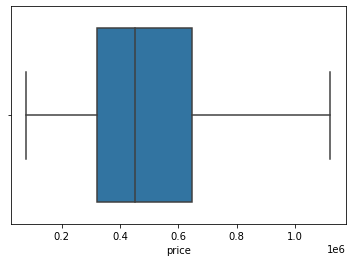

In [5]:
sns.boxplot(df['price'], showfliers=False);

In [6]:
df = df[df['price'] <= 1500000]
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,beds_baths
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,4.00
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,5.25
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,3.00
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,7.00
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,5.50
21593,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,6.50
21594,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,2.75
21595,400000.0,3,2.50,1600,2388,2.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287,5.50


In [7]:

dummy_df = dataset['grade']
dummies = pd.get_dummies(dummy_df,prefix='grade',drop_first=True)
merged = pd.concat([dataset,dummies],axis=1)
merged.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
grade_4          0
grade_5          0
grade_6          0
grade_7          0
grade_8          0
grade_9          0
grade_10         0
grade_11         0
grade_12         0
grade_13         0
dtype: int64

# A look at how data is distributed

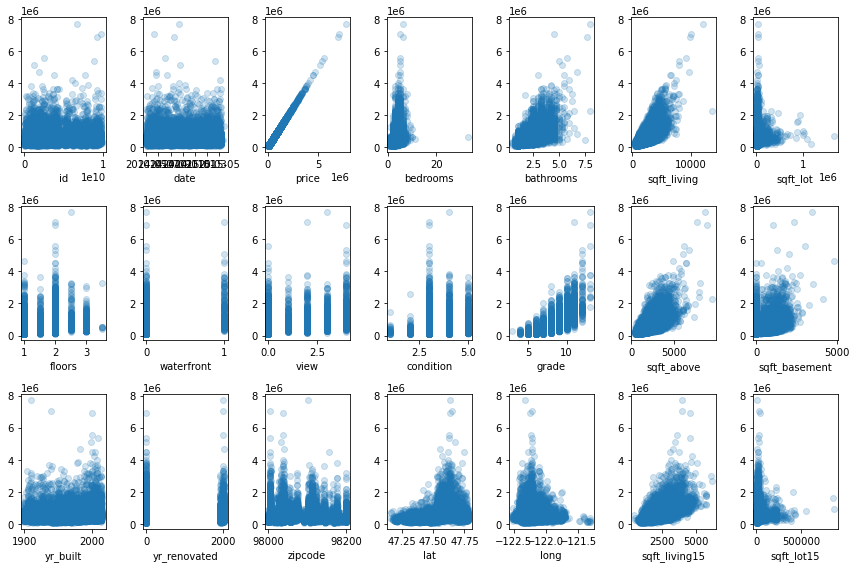

In [8]:
fig , axes = plt.subplots(nrows=3,ncols=7,figsize=(12,8))
fig.set_tight_layout(True)

for index,col in enumerate(dataset.columns):
    ax = axes[index//7][index%7]
    ax.scatter(dataset[col],dataset['price'],alpha=.2)
    ax.set_xlabel(col)

# Heatmap for a quick look at where we might start

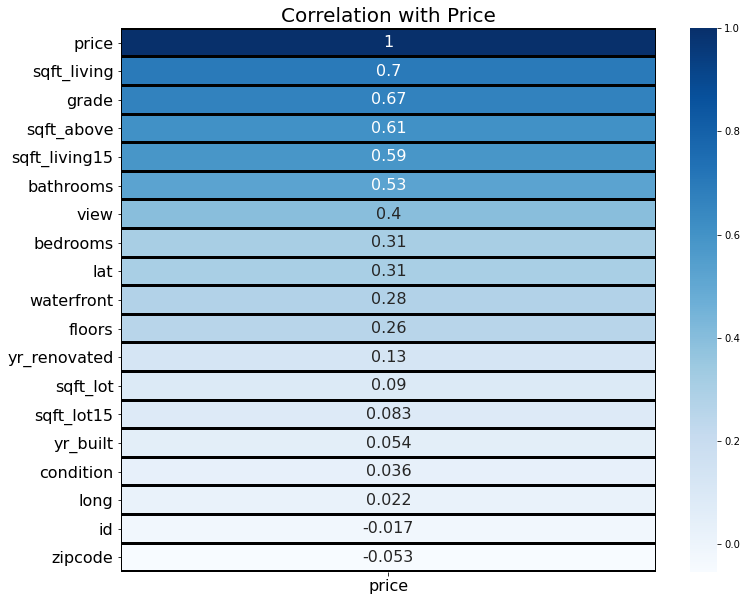

In [9]:
corr = df_train.corr()

x=corr[['price']]

fig , ax = plt.subplots(figsize=(12,10))

sns.heatmap(x.sort_values(by=['price'],ascending=0),
                          annot=True,
                          cmap='Blues',
                          annot_kws={'fontsize':16},
                          linewidth=2,
                          linecolor='black')
ax.set_title('Correlation with Price',size=20)
ax.tick_params(labelsize=16)
                          


 It seems like sqft_living has the highest correlation with price. This and grade seem to be the two highest, but grade is categorical (technically) and sqft is numerical.

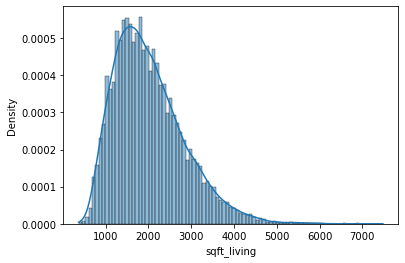

In [10]:
sns.histplot(df['sqft_living'],stat='density',kde=1);


Our data is skewed to the left.

In [11]:
df_zip = df.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
columns = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','condition','grade','sqft_living15','sqft_lot15']
new_df = pd.DataFrame(df_zip,columns=columns)
#new_df['avg_price_zipcode'] = df['zipcode'].map(lambda x: df['price'][x].mean())
price_df = new_df['price']
d = price_df.to_dict()
d

{'98039': 1145666.6666666667,
 '98004': 968900.971563981,
 '98040': 957992.6396396396,
 '98112': 858707.7660550459,
 '98109': 780484.75,
 '98005': 773510.3024691358,
 '98006': 770106.6954643629,
 '98119': 769066.235632184,
 '98075': 763022.0426136364,
 '98102': 755661.8350515463,
 '98105': 755378.2285714286,
 '98199': 732288.9636963697,
 '98033': 719714.3694581281,
 '98077': 665802.1846153847,
 '98074': 663808.8640552995,
 '98053': 655978.9368686868,
 '98052': 640682.1433566434,
 '98007': 617254.0212765958,
 '98115': 609545.7422145329,
 '98116': 604844.7423312883,
 '98122': 602843.4822695035,
 '98177': 602333.1069958848,
 '98029': 600026.1603773584,
 '98027': 588975.8267326732,
 '98008': 581616.0145985401,
 '98103': 581565.6083333333,
 '98117': 576834.808318264,
 '98072': 566397.3198529412,
 '98107': 562928.821969697,
 '98144': 536780.495468278,
 '98136': 534712.0038461538,
 '98065': 524840.3029315961,
 '98024': 499995.54054054053,
 '98011': 490377.1076923077,
 '98070': 489382.01709401

In [12]:
df_grade = df.groupby('grade').mean().sort_values(by=['price'],ascending=False)
grade_df = pd.DataFrame(df_grade,columns=columns)
grade_df


,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_living15,sqft_lot15
grade,,,,,,,,,
12,1.307609e+06,4.130435,3.782609,4733.913043,35821.130435,3.086957,NaN,4298.260870,34773.434783
11,1.094389e+06,4.101961,3.332353,4130.784314,35560.862745,3.098039,NaN,3602.792157,27228.866667
10,9.070395e+05,3.858628,2.939969,3431.964657,29942.697505,3.170478,NaN,3011.596674,22664.461538
9,7.353173e+05,3.761395,2.655172,2843.442331,20928.464923,3.248910,NaN,2594.503369,17590.785573
8,5.374594e+05,3.478808,2.346813,2179.659603,13496.928311,3.353974,NaN,2063.724338,11353.206291
7,4.020138e+05,3.257860,1.829599,1688.937235,11770.449833,3.491193,NaN,1679.040245,10617.196210
6,3.019166e+05,2.685967,1.243499,1191.561335,12646.953876,3.539745,NaN,1389.247301,11020.924926
3,2.620000e+05,1.000000,0.750000,520.000000,12981.000000,5.000000,NaN,1340.000000,12233.000000
5,2.485240e+05,2.388430,1.113636,983.326446,24019.909091,3.491736,NaN,1380.570248,16122.433884


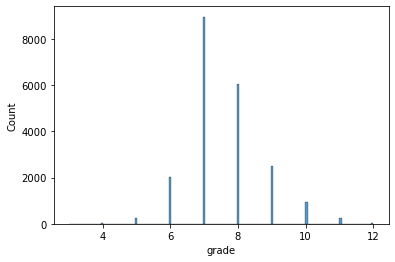

In [13]:
sns.histplot(df['grade']);

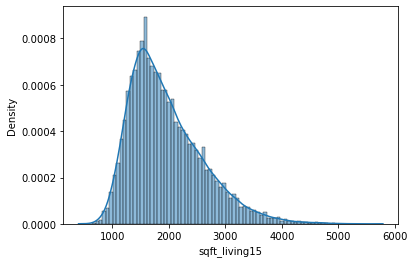

In [14]:
sns.histplot(df['sqft_living15'],stat='density',kde=1);

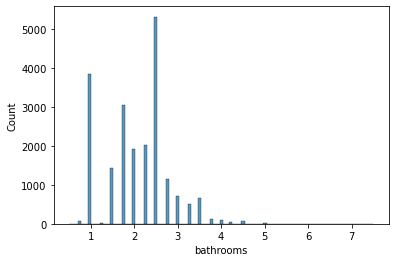

In [15]:
sns.histplot(df['bathrooms']);

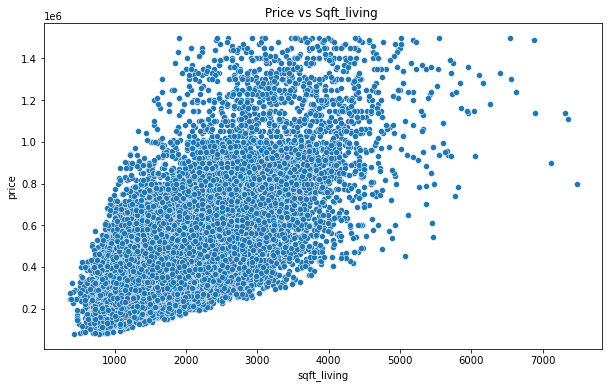

In [16]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Sqft_living ')
sns.scatterplot(x=df['sqft_living'],y=df['price']);

Price and sqft_living seem to have a linear relationship based on this data.

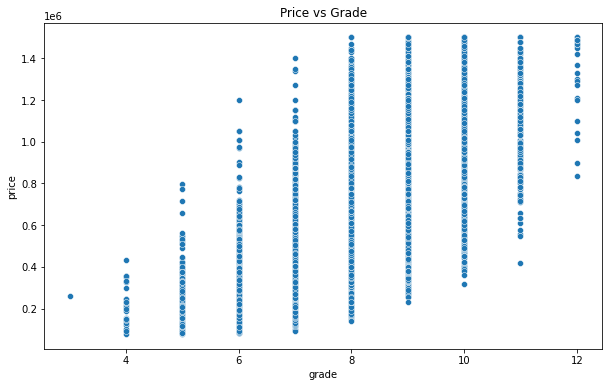

In [17]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Grade')

sns.scatterplot(x=df['grade'],y=df['price']);

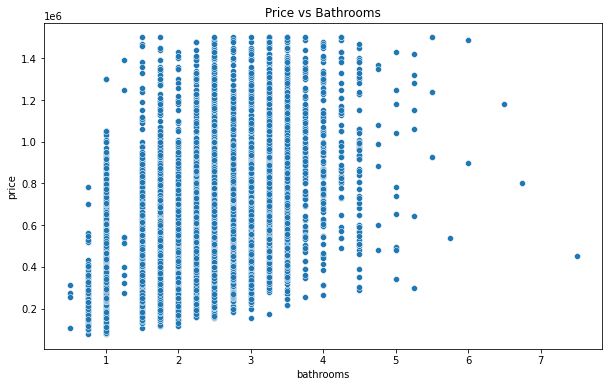

In [18]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Bathrooms')

sns.scatterplot(x=df['bathrooms'],y=df['price']);

# Looking at score with most correlated feature

In [19]:
X = df['sqft_living']
y = df['price']


dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X,y)
dummy_regr.predict(X)
dummy_regr.score(X,y)

0.0

In [20]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train).reshape(-1,1)
Y_train = np.array(Y_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)
Y_test = np.array(Y_test).reshape(-1,1)


model = LinearRegression()
model.fit(X_train,Y_train)

Y_pred = model.predict(X_test)

model.coef_,model.intercept_,model.score(X_train,Y_train),metrics.r2_score(Y_pred,Y_test)

(array([[198.47483095]]),
 array([100295.1064247]),
 0.43230117647015087,
 -0.3013018044634592)

In [21]:
#formula = 'price ~ sqft_living + beds_baths +  grade_5 + grade_6 +  grade_8 + grade_9 +grade_10+grade_11+grade_12+grade_13' 
#model = ols(formula, data=merged)
#model.fit().summary()

Our first model uses one feature and can explain 49.2% of price variances. Y= 282.20*sqft - 46447 R2 = 49.2

In [22]:
X = pd.DataFrame(df,columns = ['sqft_living','grade'])
y = df['price']

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X,y)
dummy_regr.predict(X)
dummy_regr.score(X,y)

0.0

In [23]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit(X_train).transform(X_train)

model = LinearRegression()
model.fit(X_train,Y_train)

y_hat = model.predict(X_train)

resid = Y_train-y_hat

Y_pred = model.predict(Scaler.transform(X_test))

model.coef_,model.intercept_,model.score(X_train,Y_train) , metrics.r2_score(Y_pred,Y_test) 


(array([ 90075.10262207, 100354.93892464]),
 501039.57554554084,
 0.5070649766585644,
 0.014778043950760544)

In [24]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,11.61538,sqft_living
1,11.61538,grade


In [25]:
formula2 = 'price ~ sqft_living + grade '
model = ols(formula2, data=df_train)
model.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                 1.241e+04
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        16:44:44   Log-Likelihood:            -2.9913e+05
No. Observations:               21597   AIC:                         5.983e+05
Df Residuals:                   21594   BIC:                         5.983e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.028e+05   1.33e+04    -45.181      0.000   -6.29e+05   -5.77e+05
sqft_living   184.1215      2.872     64.102      0.000     178.491     189.751
grade        9.925e+04   2247.784     44.155      0.000    9.48e+04    1.04e+05
==============================================================================
Omnibus:                    16960.955   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1005795.090
Skew:                           3.304   Prob(JB):                         0.00
Kurtosis:                      35.773   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our second model uses grade and square feet that gives us a better explanation of variances in price.
*Y= 183.33*sqft + 101962*grade - 621259 
R2 = 54%* 





In [26]:
formula3 = 'price ~ sqft_living + grade + beds_baths + waterfront + condition'
model = ols(formula3, data=df)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     4774.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        16:44:44   Log-Likelihood:            -2.8381e+05
No. Observations:               21081   AIC:                         5.676e+05
Df Residuals:                   21075   BIC:                         5.677e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.791e+05   1.28e+04    -45.251      0.000   -6.04e+05   -5.54e+05
sqft_living   124.7971      2.652     47.058      0.000     119.599     129.995
grade        9.742e+04   1590.699     61.247      0.000    9.43e+04    1.01e+05
beds_baths  -1.476e+04   1235.029    -11.951      0.000   -1.72e+04   -1.23e+04
waterfront   3.328e+05      2e+04     16.673      0.000    2.94e+05    3.72e+05
condition    4.913e+04   1836.097     26.755      0.000    4.55e+04    5.27e+04
==============================================================================
Omnibus:                     2931.532   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5796.434
Skew:                           0.870   Prob(JB):                         0.00
Kurtosis:                       4.889   Cond. No.                     3.72e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# An early model where we are exploring features

In [27]:
X = pd.DataFrame(df,columns = ['sqft_living','grade','beds_baths','condition'])
y = df['price']

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
ss = StandardScaler()
ss.fit(X).transform(X)

model.fit(X,y)

y_hat = model.predict(X_test)

resid = Y_test-y_hat

model.coef_,model.intercept_,model.score(X_train,Y_train), metrics.r2_score(y_hat,Y_test) 


(array([   126.21907374,  97254.98772087, -15583.36160879,  49494.89950074]),
 -576277.5307221226,
 0.527392608918078,
 0.08114652426669411)

This model performed poorly on the test set.

In [28]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,18.639620,sqft_living
1,41.320662,grade
2,32.204451,beds_baths
3,18.163934,condition


# R2 score with grades as dummy variables

In [33]:
X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

(array([-2.08886630e+04,  3.38052169e+04,  1.20000807e+05,  1.54931767e+04,
         5.16012392e+04,  3.91225271e+04,  1.82884744e+04,  8.75081352e+02,
        -6.84693005e+04,  3.37678166e+03, -3.32985884e+04,  8.61811344e+04,
        -2.79719618e+04,  1.89769954e+04, -7.25733888e+03, -4.00057729e+16,
        -1.25222467e+17, -3.42998639e+17, -5.79070567e+17, -5.27999484e+17,
        -3.82065159e+17, -2.64141134e+17, -1.56663703e+17, -7.47351282e+16,
        -2.53106935e+16]),
 538609.1895668083,
 0.7241148873311836,
 -2.1653658305752216e+21)

Explaining variances at 73%, this is our best model we have come up with.

# R2 Score with Grade as Normal

In [34]:
X = dataset.drop(['price','id','date','sqft_lot','sqft_above','view'], axis = 1).select_dtypes(exclude = ['object', 'category'])
#X = X.drop(['id','date','sqft_lot','sqft_above'],axis=1)
y=dataset['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

(array([-37609.20194707,  33502.23327256, 154520.81617786,   8194.71499042,
         67357.85145188,  16043.75388149, 119595.2203818 ,  -2522.4633234 ,
        -84745.7706637 ,   2566.70906647, -28203.11581313,  80665.61654846,
        -30829.68916557,  26925.16679933,  -5035.62713527]),
 538633.7840599093,
 0.6933744789788556,
 0.6761336424705153)

This model performs lower on the testing set, meaning the dummy variables helped with our R2.

In [35]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,2.328013e+01,bedrooms
1,2.832487e+01,bathrooms
2,3.662867e+01,sqft_living
3,1.667134e+01,floors
4,1.033515e+00,waterfront
5,3.391598e+01,condition
6,1.468470e+02,grade
7,2.596895e+00,sqft_basement
8,8.595413e+03,yr_built
9,1.295671e+00,yr_renovated


<AxesSubplot:>

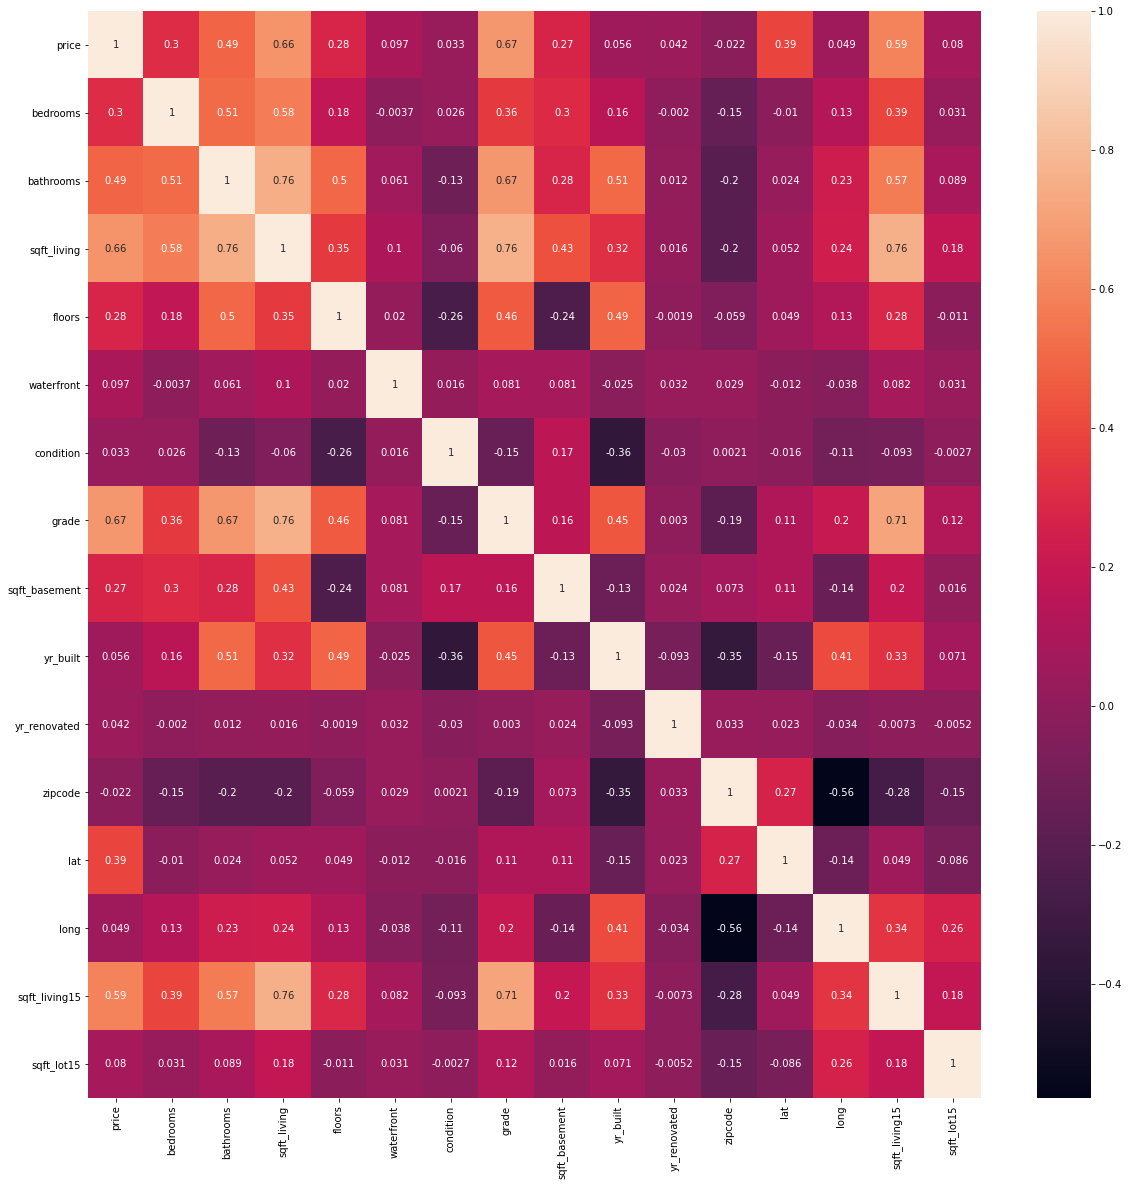

In [36]:
heatmap_data=pd.concat([Y_train,X],axis=1)

fig , ax = plt.subplots(figsize=(20,20))

sns.heatmap(heatmap_data.corr(),annot=True)

In [45]:
X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade','sqft_living15','bathrooms','grade_7'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

(array([-16308.09412717, 144292.4051698 ,  20767.49731764,  51149.55545665,
         41314.94142964,  19023.76567917,   2808.43717376, -60339.22672593,
          3944.60438557, -34902.18831611,  87120.88222872, -26562.61808724,
         -7261.96925403,  -2968.45006754,  -8585.10999741, -14091.904898  ,
         32803.25959418,  63366.88402831,  82177.22435802,  84068.66889661,
         66400.98595741,  34560.5110554 ]),
 538633.7840599101,
 0.7205975072079328,
 0.7302976662121339)

In [38]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,2.369698e+01,bedrooms
1,2.973560e+01,sqft_living
2,1.554200e+01,floors
3,1.186929e+00,waterfront
4,1.494217e+00,view
5,3.399118e+01,condition
6,2.638590e+00,sqft_basement
7,8.158615e+03,yr_built
8,1.294138e+00,yr_renovated
9,1.609357e+06,zipcode


In [47]:
X=merged.drop(['id','date','view','sqft_lot','grade_7','sqft_above','grade','sqft_living15','bathrooms','sqft_lot15','lat','long','yr_built','bedrooms','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

group = X_train.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
zip_group = group['price']
zip_dict = zip_group.to_dict()
X_train['avg_zip_price'] = X_train['zipcode'].map(zip_dict)
X_train.drop('price',inplace=True,axis=1)
X_train

<ipython-input-47-99b70cd3ab6a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['avg_zip_price'] = X_train['zipcode'].map(zip_dict)
C:\Users\sethk\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,sqft_living,waterfront,yr_renovated,zipcode,grade_4,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,avg_zip_price
15714,1350,0.0,1959.0,98004,0,0,0,0,0,0,0,0,0,1.343674e+06
10920,1830,0.0,1928.0,98040,0,0,0,0,0,0,0,0,0,1.198157e+06
2782,3527,0.0,2005.0,98198,0,0,0,0,0,0,0,0,0,3.051686e+05
14991,1920,0.0,0.0,98027,0,0,0,1,0,0,0,0,0,6.081606e+05
19542,1980,0.0,1910.0,98119,0,0,0,1,0,0,0,0,0,8.556661e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11323,3400,0.0,0.0,98038,0,0,0,0,1,0,0,0,0,3.684502e+05
12006,2430,0.0,1952.0,98004,0,0,0,1,0,0,0,0,0,1.343674e+06
5409,1620,0.0,0.0,98125,0,0,1,0,0,0,0,0,0,4.666638e+05
866,3460,0.0,0.0,98056,0,0,0,0,0,0,0,0,0,4.130930e+05


In [48]:
print(pd.Series(final_model.coef_, index=X_train.columns, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

sqft_living      137037.951597
waterfront        69441.907501
yr_renovated       7108.942106
zipcode           30483.668038
grade_4             -79.253549
grade_5               6.681752
grade_6               7.758981
grade_8            8340.490410
grade_9           29797.772265
grade_10          48091.523990
grade_11          60079.639625
grade_12          55693.931412
grade_13          32796.130316
avg_zip_price    161486.782822
Name: Coefficients, dtype: float64

Intercept: 538633.7840599025


In [40]:
X_test['avg_zip_price'] = X_test['zipcode'].map(zip_dict)
X_test.drop('price',inplace=True,axis=1)
X_test


<ipython-input-40-d9cb97517490>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['avg_zip_price'] = X_test['zipcode'].map(zip_dict)
C:\Users\sethk\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,sqft_living,waterfront,yr_renovated,zipcode,grade_4,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,avg_zip_price
19009,3100,0.0,0.0,98103,0,0,0,0,0,0,0,0,0,5.789110e+05
6370,3610,0.0,0.0,98075,0,0,0,0,0,1,0,0,0,7.920995e+05
13983,1070,0.0,0.0,98002,0,0,1,0,0,0,0,0,0,2.326277e+05
7837,4010,0.0,1990.0,98004,0,0,0,1,0,0,0,0,0,1.343674e+06
9491,1930,0.0,0.0,98155,0,0,0,1,0,0,0,0,0,4.305656e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,620,0.0,0.0,98117,0,0,1,0,0,0,0,0,0,5.727042e+05
14640,2300,0.0,0.0,98053,0,0,1,0,0,0,0,0,0,6.814280e+05
19802,2710,0.0,0.0,98038,0,0,0,1,0,0,0,0,0,3.684502e+05
1012,1780,0.0,0.0,98008,0,0,0,1,0,0,0,0,0,6.512965e+05


In [41]:
#X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade','grade_7','sqft_living15','bathrooms','sqft_lot15','lat','long','yr_built','bedrooms','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
#y=merged['price']

#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

final_model = LinearRegression()
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
final_model.coef_, final_model.intercept_, final_model.score(X_train, y_train), final_model.score(X_test, y_test)

(array([ 1.37037952e+05,  6.94419075e+04,  7.10894211e+03,  3.04836680e+04,
        -7.92535494e+01,  6.68175219e+00,  7.75898092e+00,  8.34049041e+03,
         2.97977723e+04,  4.80915240e+04,  6.00796396e+04,  5.56939314e+04,
         3.27961303e+04,  1.61486783e+05]),
 538633.7840599025,
 0.7835730244009957,
 0.7935934061690588)

In [43]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,8.219262,price
1,17.598884,sqft_living
2,1.106102,waterfront
3,1.276331,yr_renovated
4,11.444621,zipcode
5,1.007044,grade_4
6,1.045038,grade_5
7,1.298158,grade_6
8,1.902923,grade_8
9,1.873330,grade_9


# Investigating Linearity

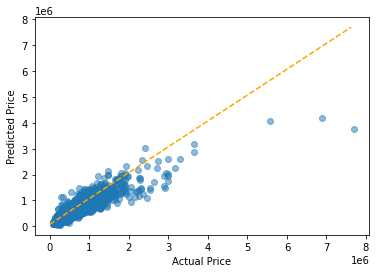

In [44]:
preds = final_model.predict(X_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle = '--', color = 'orange', label = "Perfect Fit")
ax.scatter(y_test, preds, alpha=.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price");


# Investigating Normality

In [ ]:
residuals = (y_test - y_pred)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

# Investigating Homoskedasticity

In [ ]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");